# Setup + Utils

In [74]:
import pyspark.sql.functions as F
from pyspark.sql import Row
import pyspark.sql.types as T
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import Counter
from IPython.display import Markdown, display
from moztelemetry import Dataset
from pyspark.sql.window import Window

sc.setLogLevel("INFO")
sns.set(style='whitegrid')
% matplotlib inline

In [75]:
def md(md_text):
    """ Print Markdown text so that it renders correctly in the cell output. """
    display(Markdown(md_text))
    
    
def date_plus_x_days(date, x):
    new_date = dt.datetime.strptime(date, '%Y%m%d') + dt.timedelta(days=x)
    return new_date.strftime('%Y%m%d')

def _date_diff(d1, d2):
    if d1 and d2:
        try:
            d1, d2 = [pd.to_datetime(i, format="%Y%m%d") for i in (d1, d2)]
            return (d1 - d2).days
        except ValueError:
            pass
    return None
    
def get_install_rates_disco(d, grouper=['branch']):
    # how many clients had 1+ install per branch
    installs = (
        d.filter("ping_type = 'install'")
         .filter("addon_id not like '%mozilla%'")
         .filter("src = 'about:addons'")
    )
    
    distinct_clients_that_installed = (
         installs
         .groupby(grouper)
         .agg(F.countDistinct('client_id')
               .alias("distinct_clients_that_installed"))
         .toPandas()
    )

    # installs per client
    installs_per_client = (
        installs
         .groupby(grouper + ['client_id'])
         .agg(F.countDistinct('addon_id')
               .alias("n_installs_per_client"))
         .groupby(grouper)
         .agg(F.avg("n_installs_per_client").alias("avg_num_installs_per_client"))
         .toPandas()
    )
    
    # total distinct clients
    total_counts = (
        d.select(["client_id"] + grouper)
         .filter("discopane_loaded = true")
         .distinct()
         .groupby(grouper).count().toPandas()
    )
    
    
    total_counts.columns = grouper +  ['total_distinct_clients']

    # join for getting proportions
    m = (
        pd.merge(
            pd.merge(distinct_clients_that_installed, 
                     installs_per_client, on=grouper), 
            total_counts, on=grouper)
    )
    
    m['prob_at_least_one_install'] = m.distinct_clients_that_installed / m.total_distinct_clients
    m['src'] = 'about:addons'
    return m

def get_install_rates_AMO_total(d, grouper=['branch'], saw_treatment=True):
     # how many clients had 1+ install per branch
        
    
    treatment_indicator = (
         d.groupby("client_id")
          .agg(F.max(bool2int('discopane_loaded')).alias('saw_treatment'))
    )
    
    d_group = d.join(treatment_indicator
                     .filter(treatment_indicator.saw_treatment == int(saw_treatment)),
                     on='client_id')
    
    if saw_treatment == False:
        # comparison by branch irrelevant 
        # if the sample never navigated to discopane
        d_group = d_group.withColumn("branch", F.lit("All"))
    
    installs = (
        d_group.filter("ping_type = 'install'")
         .filter("addon_id not like '%mozilla%'")
         .filter("src = 'AMO'")
    )
    
    
    distinct_clients_that_installed = (
         installs
         .groupby(grouper)
         .agg(F.countDistinct('client_id')
               .alias("distinct_clients_that_installed"))
         .toPandas()
    )

    installs_per_client = (
        installs
         .groupby(grouper + ['client_id'])
         .agg(F.countDistinct('addon_id')
               .alias("n_installs_per_client"))
         .groupby(grouper)
         .agg(F.avg("n_installs_per_client").alias("avg_num_installs_per_client"))
         .toPandas()
    )
    
    # total distinct clients
    total_counts = (
        d_group.select(["client_id"] + grouper)
         .distinct()
         .groupby(grouper).count().toPandas()
    )
    
    
    total_counts.columns = grouper +  ['total_distinct_clients']

    # join for getting proportions
    m = (
        pd.merge(
            pd.merge(distinct_clients_that_installed, 
                     installs_per_client, on=grouper), 
            total_counts, on=grouper)
    )
    
    m['prob_at_least_one_install'] = m.distinct_clients_that_installed / m.total_distinct_clients
    m['src'] = 'AMO'
    return m

def get_visitation_rates(d, grouper=['branch']):
    visits = (
        d.filter("ping_type = 'disco-pane-loaded'")
         .filter("dwell_time > 0")
         .groupby(grouper).count().toPandas()
    )
    visits.columns = grouper +  ["total_visits"]

    total_counts = (
        d.select(["client_id"] + grouper)
         .filter("discopane_loaded = true")
          .distinct()
         .groupby(grouper).count().toPandas()
    )
    total_counts.columns = grouper +  ['total_distinct_clients']


    mv = pd.merge(visits, total_counts, on=grouper)
    mv['visits_per_client'] = mv.total_visits / mv.total_distinct_clients
    return mv

def get_uninstall_rates(d, grouper=['branch']):
    first_install = (
    d.filter("ping_type = 'install'")
     .filter("src = 'about:addons'")
         .filter("addon_id not like '%mozilla%'")
         .groupby("client_id").agg(F.min("submission_date_s3").alias("first_install_date"))
    ).cache()

    fields = ['client_id', 'addon_id'] + grouper

    installs = (
        d.filter("ping_type = 'install'")
         .filter("src = 'about:addons'")
         .filter("addon_id not like '%mozilla%'")
         .select(fields)
         .distinct()
    ).cache()


    installs_and_final_addons = (
        installs.groupby(["client_id"] + grouper)
                .agg(F.collect_set("addon_id").alias("installs"))
        .join(first_install, on='client_id')
        .join(d.groupby("client_id")
               .agg(F.max("submission_date_s3").alias("submission_date_s3"))
               .join(d.select("client_id", "submission_date_s3", F.explode("current_addons").alias("addon_id"))
                       .filter("addon_id not like '%mozilla%'"),
                    on=['client_id', 'submission_date_s3'])
               .withColumnRenamed("submission_date_s3", "last_ping")
               .groupby("client_id", "last_ping")
               .agg(F.collect_set("addon_id").alias("retained")),
              on='client_id')      
    )

    uninstalls = (
     installs_and_final_addons
        .filter("last_ping > first_install_date")
        .withColumn('not_retained', set_diff("installs", "retained")) 
        .select(grouper + [F.explode("not_retained")]) 
        .groupby(grouper)
        .agg(F.count(F.lit(1)).alias("n_installed"))
        .join(
          installs_and_final_addons
            .select(grouper + [F.explode("installs")]) 
            .groupby(grouper)
            .agg(F.count(F.lit(1)).alias("n_total")),
         on=grouper)
    ).toPandas()


    uninstalls['n_retained'] = uninstalls.n_total - uninstalls.n_installed
    uninstalls['addon_retention_rate'] = uninstalls.n_retained / uninstalls.n_total
    return uninstalls

def _format_creation_date(d):
    d = d.split('.')[0]
    return long(re.sub("[-T:]", '', d))

format_creation_date = F.udf(_format_creation_date, T.LongType())
set_diff = F.udf(lambda x, y: list(set(x) - set(y)), T.ArrayType(T.StringType()))
date_diff = F.udf(_date_diff, T.LongType())
branch_counts = lambda x: x.groupby('branch').agg(F.countDistinct("client_id")).toPandas()
bool2int = F.udf(lambda x: 1 if x else 0, T.IntegerType())

# Data Loading

In [76]:
S3_PATH = "s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/data"
START_DATE = '20180312'
RELOAD_MS = False

data = sqlContext.read.parquet(S3_PATH)
exp_data = data.filter("submission_date_s3 >= '{}'".format(START_DATE))
N = exp_data.count()
print "n pings:", N
print "n clients:", exp_data.select("client_id").distinct().count()

branch_counts(exp_data)

n pings: 8961698
n clients: 3493614


,branch,count(DISTINCT client_id)
0,ensemble-taar,1164434
1,control,1165835
2,linear-taar,1163444


In [77]:
exp_data.printSchema()

root
 |-- addon_id: string (nullable = true)
 |-- clicked_button: boolean (nullable = true)
 |-- client_id: string (nullable = true)
 |-- creation_date: string (nullable = true)
 |-- current_addons: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- discopane_loaded: boolean (nullable = true)
 |-- dwell_time: long (nullable = true)
 |-- locale: string (nullable = true)
 |-- ping_type: string (nullable = true)
 |-- saw_popup: boolean (nullable = true)
 |-- src: string (nullable = true)
 |-- start_time_utc: long (nullable = true)
 |-- submission_date_s3: string (nullable = true)
 |-- branch: string (nullable = true)



# Cleaning

We must verify our assumptions and requirements about the experiment data before performing any analysis. Any clients that do not conform to these assumptions will be excluded. The code below continuously adds non-conforming `client_id`s to a blacklist.




#### Assumption: Each client has a `profile_creation_date` within 21 days of their first experiment ping, **and** each client has not submitted a main ping > 21 days before their first experimental ping

In [78]:
if not RELOAD_MS:
    # load pre aggregated data, generated from 'else' statement
    # as it is quite expensive
    ms_min_dates = (sqlContext.read
                    .parquet("s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/ms-min-dates/"))
    blacklist_clients = (sqlContext.read
                         .parquet("s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/blacklist-clients/")
                         .select('client_id').distinct())
    print "loading pre-aggregated datasets"
else:
    # load main_summary a month before study start date
    ms = (
        sqlContext.read.option("mergeSchema", True)
                  .parquet("s3://telemetry-parquet/main_summary/v4")
                  .filter("submission_Date_s3 > '{}'".format(date_plus_x_days(START_DATE, -30)))
                  .filter("submission_date_s3 <= '{}'".format('20180423'))
                  .filter("app_name = 'Firefox'")
                  .filter("normalized_channel = 'release'")
                  .select("client_id", 
                          "profile_creation_date", 
                          'locale', 'profile_creation_date', "submission_date_s3", 
                          "sample_id", "active_addons", "apple_model_id", "memory_mb")
    )

    # clients with different locales, apple_model_id (null for PC)
    # or memory_mb are excluded. Potentially ignores clients
    # with new hardware.
    blacklist_clients = (
        ms.select("client_id", 'locale', 'apple_model_id', 'memory_mb').distinct()
          .groupby('client_id').agg(F.count(F.lit(1)).alias('count'))
    ).filter("count > 1").select("client_id", F.lit(1).alias("blacklist"))

    # get the min submission_date_s3 and min PCD (should be constant)
    # per client
    ms_min_dates = (
        ms.groupBy("client_id")
          .agg(F.min('profile_creation_date').alias('min_pcd'),
               F.min('submission_date_s3').alias("min_submission_date"))
    )
    
    # write to s3 for faster iterations moving forward
    (ms_min_dates
     .repartition(50)
     .write
     .mode("overwrite")
     .parquet("s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/ms-min-dates/"))

    # write to s3 for faster iterations moving forward
    (blacklist_clients
     .repartition(10)
     .write
     .mode("overwrite")
     .parquet("s3://net-mozaws-prod-us-west-2-pipeline-analysis/taarv2/blacklist-clients/"))

    
# join with blacklist clients, and filter clients
# with multiple locales, hardware ids and/or memory
joined = (
    exp_data.join(ms_min_dates, on='client_id', how='left')
        .withColumn("min_pcd", 
                    F.from_unixtime(F.col("min_pcd") * 60 * 60 * 24, 'yyyyMMdd'))
).cache()

loading pre-aggregated datasets


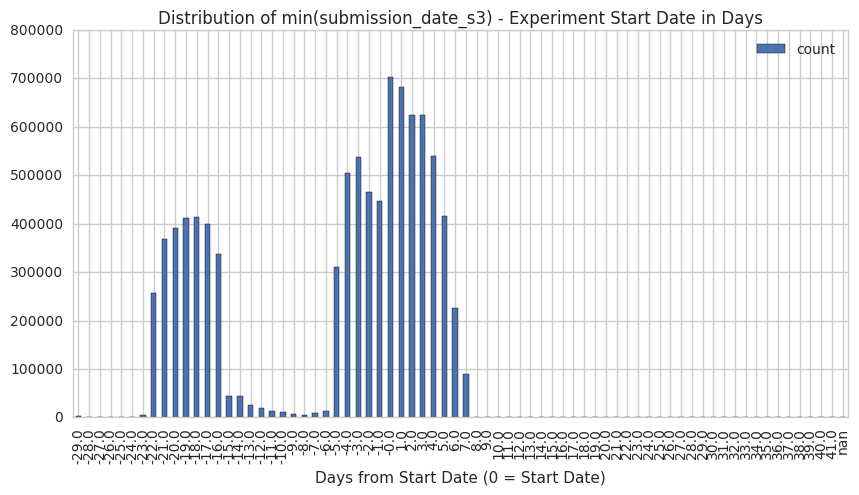

In [79]:
min_start_dates = joined.groupBy("client_id").agg(F.min("start_time_utc").alias("min_start_date"))

agg = (
    joined.join(min_start_dates, on="client_id")
            .withColumn("days_before_first_ping", date_diff("min_submission_date", "min_pcd"))
            .withColumn("days_before_exp_start", date_diff(F.lit(START_DATE), "min_submission_date"))
)

days_before = agg.groupby("days_before_exp_start").count().toPandas()
days_before['days_before_exp_start'] *= -1

plt.rcParams['figure.figsize'] = (10, 5)
days_before.sort_values("days_before_exp_start").plot.bar(x="days_before_exp_start")
plt.title("Distribution of min(submission_date_s3) - Experiment Start Date in Days")
plt.xlabel("Days from Start Date (0 = Start Date)")

In [80]:
# no client should have a ping or pcd > 21 days from the experiment start date
# validating normandy targetting critera
# join back with exp_data and blacklist since this 
# the current blacklist considers all of main_summary, not just the exp data
blacklist_clients = (
    agg.filter("min_submission_date < '{}'".format(date_plus_x_days(START_DATE, -21)))
       .filter("min_pcd < '{}'".format(date_plus_x_days(START_DATE, -21)))
       .select("client_id")
       .join(exp_data.select("client_id"), on='client_id', how='inner')
       .join(blacklist_clients, on='client_id', how='inner')
       .select("client_id").distinct()
)


bl_n = blacklist_clients.count()
print "{} clients were added to the blacklist".format(bl_n)

13181 clients were added to the blacklist


#### Assumption: clients that installed from disco-pane have a true value for `discopane_loaded`

In [81]:
w = Window.partitionBy("client_id").orderBy("creation_date_formatted")
cum = (F.sum('dwell_time').over(w))

cum_dwell = (exp_data.withColumn("creation_date_formatted", format_creation_date("creation_date"))
         .withColumn("dwell_time_cum", cum)
         .sort('client_id', 'creation_date_formatted')
         .select("client_id", 'creation_date_formatted', 
                 'creation_date', 'discopane_loaded', 'dwell_time_cum'))


# override discopane_loaded if dwell_time_cum is non-zero
# since a client should by definition have loaded the page
# if they dwelled for more than 0 seconds. Leave discopane_loaded
# untouched if it is true. This 
exp_data = (
    exp_data.join(cum_dwell.select("client_id", 
                               'creation_date', 
                               'dwell_time_cum'),
                  on=['client_id', 'creation_date'])
            .withColumn("discopane_loaded", F.col('discopane_loaded') | (F.col('dwell_time_cum') > 0))
)

# initialize blacklist
# as clients shown to have installed from
# discopane without ever loading it (~400 pings, so small)
blacklist_clients = blacklist_clients.unionAll(
    exp_data.filter("ping_type='install' and src='about:addons' and discopane_loaded = false")
    .select("client_id").distinct()
)


# print blacklist additions and update
new_bl_n = blacklist_clients.count()
print "{} clients were added to the blacklist".format(new_bl_n - bl_n)
new_bl = new_bl_n

309 clients were added to the blacklist


#### Assumption: Each client belongs to only one branch

In [ ]:
# count the number of distinct branches per client
multiple_cohort_clients = (
    exp_data.groupBy("client_id")
        .agg(F.collect_set("branch").alias("branches"))
        .withColumn("n_branches", F.size("branches"))
        .filter("n_branches > 1")
)



blacklist_clients = (
    blacklist_clients.unionAll(multiple_cohort_clients.select("client_id").distinct())
)


# print blacklist additions and update
new_bl_n = blacklist_clients.count()
print "{} clients were added to the blacklist".format(new_bl_n - bl_n)
new_bl = new_bl_n

385 clients were added to the blacklist


#### Requirement: No Firefox Pioneers

In [ ]:
pioneers = (
    agg.select("client_id", F.explode("current_addons").alias("addon_id)"))
     .filter("addon_id like 'pioneer-enrollment%'")
     .select("client_id")
     .distinct()
)

blacklist_clients = blacklist_clients.unionAll(pioneers).distinct()

# print blacklist additions and update
new_bl_n = blacklist_clients.count()
print "{} clients were added to the blacklist".format(new_bl_n - bl_n)
new_bl = new_bl_n

#### Black List and Whitelist Filtering

In [ ]:
%%bash
# loading whitelists/blacklists generated here: 
# https://github.com/mozilla/taar/blob/master/analysis/TAARLogMunge.ipynb
aws s3 cp s3://net-mozaws-prod-us-west-2-pipeline-analysis/failed_dynamo_clients.csv .
aws s3 cp s3://net-mozaws-prod-us-west-2-pipeline-analysis/clients_served_linear.csv .
aws s3 cp s3://net-mozaws-prod-us-west-2-pipeline-analysis/clients_served_ensemble.csv .

In [ ]:
load_list = (lambda x: sc.parallelize(list(pd.read_json(x)[0]))
                          .map(lambda x: Row(client_id=x))
                          .toDF())
def filter_bl(d, bl):
    return (
        d.join(bl.select("client_id", F.lit(1).alias("in_bl")),
               on="client_id", how='left')
         .filter("in_bl is null")
    )

In [ ]:
# load whitelist and convert to SparkDF
linear_whitelist = load_list('clients_served_linear.csv').distinct()
ensemble_whitelist =  load_list('clients_served_ensemble.csv').distinct()
blacklist_clients = blacklist_clients.unionAll(load_list('failed_dynamo_clients.csv')).distinct()

print "Clients in the linear whitelist:", linear_whitelist.count()
print "Clients in the ensemble whitelist:", ensemble_whitelist.count()
print "Clients in the blacklist:", blacklist_clients.count()

# filter out blacklist from master data
exp_data_bl = filter_bl(exp_data, blacklist_clients)

linear_filtered  = exp_data_bl.filter("branch = 'linear-taar'").join(linear_whitelist, on='client_id')
ensemble_filtered = exp_data_bl.filter("branch = 'ensemble-taar'").join(ensemble_whitelist, on='client_id')
control = exp_data_bl.filter("branch = 'control'")

cols=linear_filtered.columns

d_bl_wl = (
    linear_filtered
    .unionAll(ensemble_filtered.select(cols))
    .unionAll(control.select(cols))
)

d_bl_wl = d_bl_wl.withColumn('is_en_US', d_bl_wl.locale == 'en-US').cache()

# Data Aggregation for Analysis



### Installation rates by branch / source

In [ ]:
m = pd.concat([get_install_rates_disco(d_bl_wl),
               get_install_rates_AMO_total(d_bl_wl)])
m.to_csv("installs.csv", index=False)
m.sort_values(['src', 'branch'])
m

In [ ]:
%%bash -s "$S3_PATH"
aws s3 cp installs.csv $1taar-installs.csv

### Installation rates by branch / source / en-US vs. Non en-US

In [ ]:
men = pd.concat([get_install_rates_disco(d_bl_wl, grouper=['branch', 'is_en_US']),
               get_install_rates_AMO_total(d_bl_wl, grouper=['branch', 'is_en_US'])])
men.to_csv("en-us-installs.csv", index=False)
men.sort_values(['src', 'branch'])
men

In [ ]:
%%bash -s "$S3_PATH"
aws s3 cp en-us-installs.csv $1taar-en-us-installs.csv

### Installation rates by branch / source / all locales

In [ ]:
ml = pd.concat([get_install_rates_disco(d_bl_wl, grouper=['branch', 'locale']),
               get_install_rates_AMO_total(d_bl_wl, grouper=['branch', 'locale'])])
ml.to_csv("locale-installs.csv", index=False)
ml.sort_values(['src', 'branch'])
ml

In [ ]:
%%bash -s "$S3_PATH"
aws s3 cp locale-installs.csv $1taar-locale-installs.csv

### Visitation rate to about:addons by branch

In [ ]:
mv = get_visitation_rates(d_bl_wl)
mv.to_csv("visits.csv", index=False)
mv

### Visitation rate to about:addons by branch / en-US vs. Non en-US

In [ ]:
mev = get_visitation_rates(d_bl_wl, grouper=['branch', 'is_en_US'])
mev.to_csv("en-us-visits.csv", index=False)
mev

### Visitation rate to about:addons by branch / locale

In [ ]:
mvl = get_visitation_rates(d_bl_wl, ['branch', 'locale'])
mvl.to_csv("locale-visits.csv", index=False)
mvl

In [ ]:
%%bash -s "$S3_PATH"
aws s3 cp visits.csv $1taar-visits.csv
aws s3 cp en-us-visits.csv $1taar-en-us-visits.csv
aws s3 cp locale-visits.csv $1taar-locale-visits.csv

### Add-on installations per Day/Branch

In [ ]:
daily = pd.concat([
    get_install_rates_AMO_total(d_bl_wl, grouper=['branch', 'submission_date_s3']),
    get_install_rates_disco(d_bl_wl, grouper=['branch', 'submission_date_s3'])
])

enrollment = (
    d_bl_wl.filter("ping_type='init'")
    .groupby("submission_date_s3")
    .agg(F.countDistinct("client_id").alias("count")).toPandas()
)

daily.to_csv('daily_installs.csv', index=False)
enrollment.to_csv("enrollment.csv", index=False)

In [ ]:
dd = daily[daily.src=='about:addons']
fig, ax = plt.subplots()
for g, data in dd.groupby('branch'):
    data.sort_values("submission_date_s3").plot(x='submission_date_s3', y='prob_at_least_one_install', ax=ax, label=g)
plt.show()

In [ ]:
%%bash -s "$S3_PATH"
aws s3 cp daily_installs.csv $1daily_installs.csv
aws s3 cp enrollment.csv $1enrollment.csv

### Add-on installations per Day/Branch/en-US locale

In [ ]:
daily_en_us = pd.concat([
    get_install_rates_AMO_total(d_bl_wl, grouper=['branch','is_en_US', 'submission_date_s3']),
    get_install_rates_disco(d_bl_wl, grouper=['branch', 'is_en_US', 'submission_date_s3'])
])

enrollment_en_us = (
    d_bl_wl.filter("ping_type='init'")
    .groupby("submission_date_s3", 'is_en_US')
    .agg(F.countDistinct("client_id").alias("count")).toPandas()
)

daily_en_us.to_csv('daily_installs_en_us.csv', index=False)
enrollment_en_us.to_csv("enrollment_en_us.csv", index=False)

In [ ]:
dd = daily_en_us[daily_en_us.src=='about:addons']

for en_us, data in dd.groupby("is_en_US"):
    fig, ax = plt.subplots()
    for g, data1 in data.groupby('branch'):
        (data1.sort_values("submission_date_s3")
         .plot(title="en_US:{}".format(en_us), 
               x='submission_date_s3', 
               y='prob_at_least_one_install', 
               ax=ax, label=g))
plt.show()

In [ ]:
%%bash -s "$S3_PATH"
aws s3 cp daily_installs_en_us.csv $1daily_installs_en_us.csv
aws s3 cp enrollment_en_us.csv $1enrollment_en_us.csv

### Add-on installations per Day/Branch/ Locale

In [ ]:
daily_locale = pd.concat([
    get_install_rates_AMO_total(d_bl_wl, grouper=['branch','locale', 'submission_date_s3']),
    get_install_rates_disco(d_bl_wl, grouper=['branch', 'locale', 'submission_date_s3'])
])

enrollment_locale = (
    d_bl_wl.filter("ping_type='init'")
    .groupby("submission_date_s3", 'is_en_US')
    .agg(F.countDistinct("client_id").alias("count")).toPandas()
)

daily_locale.to_csv('daily_installs_locale.csv', index=False)
enrollment_locale.to_csv("enrollment_locale.csv", index=False)

In [ ]:
dd = daily_locale[daily_locale.src=='about:addons']

for locale, data in dd.groupby("locale"):
    fig, ax = plt.subplots()
    for g, data1 in data.groupby('branch'):
        (data1.sort_values("submission_date_s3")
         .plot(title="Locale:{}".format(locale), 
               x='submission_date_s3', 
               y='prob_at_least_one_install', 
               ax=ax, label=g))
plt.show()

In [ ]:
%%bash
aws s3 cp daily_installs_locale.csv s3://telemetry-test-bucket/bmiroglio/daily_installs_locale.csv
aws s3 cp enrollment_locale.csv s3://telemetry-test-bucket/bmiroglio/enrollment_locale.csv

### Old UI vs New UI click through rate

Load pings from portion of the experiment with the old UI (excluded in all prior cells)

In [ ]:
def collapse_fields(x):
    """
    Collapsed nested field names 
    and returns a flattened object as a 
    PySpark Row to prepare for DataFrame 
    conversion
    """
    if x is None:
        x = {}
    data = x.get("payload", {}).get("data").get("attributes", {})
    addons= x.get("environment", {}).get("addons", {}).get("activeAddons", {})
    result = Row(
        client_id=x.get("clientId"),
        locale=x.get("environment", {}).get("settings", {}).get("locale"),
        branch=x.get("payload", {}).get("branch"),
        addon_id=data.get("addon_id"),
        clicked_button=data.get("clickedButton"))
    return result

old_ui = (
    Dataset.from_source("telemetry")
           .where(docType="shield-study-addon")
           .where(submissionDate=lambda x: x < START_DATE and x >= '20180305')
           .records(sc)
           .filter(lambda x: x.get("payload", {}).get("study_name") == "TAARExperimentV2")
           .filter(lambda x: x.get("payload", {}).get("addon_version") == "1.0.11")
           .filter(lambda x: x.get("payload", {}).get("testing") == False)
).map(collapse_fields).toDF()


old_clicked = old_ui.filter("clicked_button=true").select('client_id').distinct().count()
old_total = old_ui.select("client_id").distinct().count()

new_clicked = exp_data.filter("clicked_button=true").select('client_id').distinct().count()
new_total = exp_data.select("client_id").distinct().count()

In [ ]:
ctr = pd.DataFrame([[old_clicked, old_total], [new_clicked, new_total]])
ctr['branch'] = ['old', 'new']
ctr.columns = ['n_clicked', 'n_total', 'branch']

ctr['prob_click'] = ctr.n_clicked / ctr.n_total
ctr.to_csv("ctr.csv", index=False)
ctr

In [ ]:
%%bash
aws s3 cp ctr.csv s3://telemetry-test-bucket/bmiroglio/ctr.csv

### Old UI vs New UI click through rate by en-US / Non en-US

In [ ]:
old_ui = old_ui.withColumn("is_en_US", old_ui.locale == 'en-US')
exp_data = exp_data.withColumn("is_en_US", exp_data.locale == 'en-US')


old_ctr = (
    old_ui.filter("clicked_button = true")
          .groupby("is_en_US")
          .agg(F.countDistinct("client_id").alias("n_clicked"))
    .join(
    old_ui.groupby("is_en_US")
          .agg(F.countDistinct("client_id").alias("n_total")),
    on='is_en_US')
).toPandas()

old_ctr['branch'] = 'old'

new_ctr = (
    exp_data.filter("clicked_button = true")
          .groupby("is_en_US")
          .agg(F.countDistinct("client_id").alias("n_clicked"))
    .join(
    exp_data.groupby("is_en_US")
          .agg(F.countDistinct("client_id").alias("n_total")),
    on='is_en_US')
).toPandas()

new_ctr['branch'] = 'new'

ctr_en_us = pd.concat([old_ctr, new_ctr])
ctr_en_us['prob_click'] = ctr_en_us.n_clicked / ctr_en_us.n_total
ctr_en_us.to_csv("ctr-en-us.csv", index=False)
ctr_en_us


In [ ]:
%%bash

aws s3 cp ctr-en-us.csv s3://telemetry-test-bucket/bmiroglio/ctr-en-us.csv

### Old UI vs New UI click through rate by  locale

In [ ]:

old_ctr = (
    old_ui.filter("clicked_button = true")
          .groupby("locale")
          .agg(F.countDistinct("client_id").alias("n_clicked"))
    .join(
    old_ui.groupby("locale")
          .agg(F.countDistinct("client_id").alias("n_total")),
    on='locale')
).toPandas()

old_ctr['branch'] = 'old'

new_ctr = (
    exp_data.filter("clicked_button = true")
          .groupby("locale")
          .agg(F.countDistinct("client_id").alias("n_clicked"))
    .join(
    exp_data.groupby("locale")
          .agg(F.countDistinct("client_id").alias("n_total")),
    on='locale')
).toPandas()

new_ctr['branch'] = 'new'

In [ ]:
ctr_locale = pd.concat([old_ctr, new_ctr])
ctr_locale['prob_click'] = ctr_locale.n_clicked / ctr_locale.n_total
ctr_locale.to_csv("ctr-locale.csv", index=False)
ctr_locale

In [ ]:
%%bash

aws s3 cp ctr-locale.csv s3://telemetry-test-bucket/bmiroglio/ctr-locale.csv

### Add-on Retention by branch

In [ ]:
ret = get_uninstall_rates(d_bl_wl)
ret.to_csv("addon-retention.csv", index=False)
ret

### Add-on Retention by branch / en-US vs. Non en-US

In [ ]:
reten= get_uninstall_rates(d_bl_wl, grouper=['branch', 'is_en_US'])
reten.to_csv("addon-en-us-retention.csv", index=False)
reten

### Add-on Retention by branch / locale

In [ ]:
retl = get_uninstall_rates(d_bl_wl, grouper=['branch', 'locale'])
retl.to_csv("addon-locale-retention.csv", index=False)
retl

In [ ]:
%%bash
aws s3 cp addon-retention.csv s3://telemetry-test-bucket/bmiroglio/addon-retention.csv
aws s3 cp addon-en-us-retention.csv s3://telemetry-test-bucket/bmiroglio/addon-en-us-retention.csv
aws s3 cp addon-locale-retention.csv s3://telemetry-test-bucket/bmiroglio/addon-locale-retention.csv